# Creating VAE in keras to generate molecules

In [1]:
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Input, Dense, LSTM, Lambda, Reshape, TimeDistributed, Convolution1D, Flatten, GRU
from keras.models import Model
from keras import objectives
from keras.layers.core import RepeatVector
from keras.losses import MSE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History

with open('smiles.txt') as f:
    full_smiles_as_list = f.readlines()
    
SMILES_CHARS = set()
for smile in full_smiles_as_list:
    set_smile = set(smile)
    SMILES_CHARS = SMILES_CHARS.union(set_smile)

SMILES_CHARS = list(SMILES_CHARS)
SMILES_CHARS.insert(0,' ')
SMILES_CHARS.insert(1,'!')

max_smiles_len = 100
num_smiles_chars =  len(SMILES_CHARS)

input_dim = (max_smiles_len, num_smiles_chars)
output_dim = (max_smiles_len, num_smiles_chars)


smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))
index2smi = dict((i, c) for i, c in enumerate(SMILES_CHARS))

Using TensorFlow backend.


In [2]:
smi2index['\n'] = smi2index[' ']

In [3]:
latent_dim = 292
inter_dim = 488

In [4]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [5]:
def smiles_to_onehot(smiles, max_len = max_smiles_len):
    onehot = np.zeros((max_len, len(SMILES_CHARS)))
    onehot[0, smi2index['!']] = 1
    for i, c in enumerate(smiles):
        onehot[i+1, smi2index[c]] = 1
    return onehot


def smiles_decoder(onehot):
    smi = ''
    onehot = onehot.argmax( axis=-1 )
    for i in onehot:
        smi += index2smi[i]
    return smi

In [6]:
smiles_decoder(smiles_to_onehot(full_smiles_as_list[0]))

'!C[C@@]1(C(=O)C=C(O1)C(=O)[O-])c2ccccc2                                                             '

## Training data

### shape(56, 100, 34)

In [5]:
with open('smallsmiles.txt') as f:
    small_smiles_as_list = f.readlines()
    

In [6]:
X = [smiles_to_onehot(x) for x in small_smiles_as_list]
X = np.array(X)
X.shape

(57, 100, 35)

### shape(115936, 100, 34)

In [6]:
X_all = [smiles_to_onehot(x) for x in full_smiles_as_list]
X_all = np.array(X_all)
X_all.shape

(115936, 100, 36)

In [7]:
X = X_all

In [20]:
X = X_all[:10000]
X.shape

(10000, 100, 36)

## Model of the encoder

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Possible improvements <br>
- more lstm layers <br>
- lstm layer larger output dim <br>
- to avoid posteior collapse problem give less weight to KL loss

### 2 LSTM layer

In [9]:
x_input = Input(shape=input_dim)
lstm = LSTM(inter_dim, return_sequences=True)(x_input)
lstm_inter = LSTM(inter_dim)(lstm)
z_mean = Dense(latent_dim)(lstm_inter)
z_var = Dense(latent_dim)(lstm_inter)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

### Convolutional networks

In [9]:
x_input = Input(shape=input_dim)
h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x_input)
h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
h = Flatten(name='flatten_1')(h)
h = Dense(435, activation = 'relu', name='dense_1')(h)

z_mean = Dense(latent_dim, name='z_mean', activation = 'linear')(h)
z_var = Dense(latent_dim, name='z_log_var', activation = 'linear')(h)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

### Simple network

In [22]:
x_input = Input(shape=input_dim)
lstm = LSTM(64)(x_input)
z_mean = Dense(latent_dim)(lstm)
z_var = Dense(latent_dim)(lstm)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_var])
encoder = Model(x_input, z)

## Model of the decoder

### 2 LSTM Layers

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
repeated = RepeatVector(max_smiles_len)(latent_inputs)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(repeated)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(hidden_lstm)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(hidden_lstm)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(hidden_lstm)

decoder = Model(latent_inputs, x_2)

### 3 GRU layers

In [10]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h = Dense(latent_dim, name='latent_input', activation = 'relu')(latent_inputs)
h = RepeatVector(max_smiles_len, name='repeat_vector')(h)
h = GRU(488, return_sequences = True, name='gru_1')(h)
h = GRU(488, return_sequences = True, name='gru_2')(h)
h = GRU(488, return_sequences = True, name='gru_3')(h)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(h)

decoder = Model(latent_inputs, x_2)

### SImple 1 lstm decoder

In [21]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
repeated = RepeatVector(max_smiles_len)(latent_inputs)
hidden_lstm = LSTM(inter_dim, return_sequences=True)(repeated)
x_2 = TimeDistributed(Dense(num_smiles_chars, activation='softmax'), name='decoded_mean')(repeated)

decoder = Model(latent_inputs, x_2)

## Loss functions

In [11]:
def calculate_loss(x, x_decoded):
    x = K.flatten(x)
    x_decoded = K.flatten(x_decoded)
    recon = max_smiles_len * objectives.binary_crossentropy(x, x_decoded)

    
    kl = 0.5 * K.sum(K.exp(z_var) + K.square(z_mean) - 1. - z_var,axis = -1)
    #kl *= 0.1
    return recon + kl

In [9]:
def z_loss(x, x_new):
    #xent_loss = objectives.mse(x, x_new)
    kl_loss = - 0.5 * K.mean(1 + z_var - K.square(z_mean) - K.exp(z_var))
    # loss = kl_loss + xent_loss
    return kl_loss

## Testing the decoder

In [21]:
decoder.compile(loss=MSE, optimizer='adam')

In [24]:
Y = np.zeros((10000,292))

In [25]:
decoder.fit(Y, X, epochs=1, batch_size=100)

Epoch 1/1
 1400/10000 [===>..........................] - ETA: 2:10 - loss: 0.0109

KeyboardInterrupt: 

In [26]:
test_input = np.zeros((3,292))

In [27]:
result = decoder.predict(test_input)

In [28]:
result.shape

(3, 100, 35)

## Testing the encoder

In [29]:
encoder.compile(loss=calculate_loss, optimizer='adam')

In [31]:
encoder.fit(X, X, epochs=10, batch_size=1)

Epoch 1/10


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv_1_1/convolution (defined at C:\Users\ivani\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_15343]

Function call stack:
keras_scratch_graph


In [26]:
X1 = X[0:1]
X1 = np.reshape(X1, (1,100,57))

In [27]:
vec = encoder.predict(X1)
vec

array([[-8.1301773e-01, -2.6299402e-01, -9.8160648e-01, -1.2278748e+00,
        -1.1572304e+00, -1.5604430e+00, -1.3140545e+00, -7.6917696e-01,
        -2.4372327e+00,  1.0624061e+00, -3.0992565e-01,  8.3419043e-01,
         5.6062818e-01, -1.3172098e-01, -9.5717466e-01, -2.1324940e+00,
         5.0561869e-01,  2.7011657e-01,  5.0852150e-01, -1.7143270e+00,
         8.7156326e-01,  7.9136580e-01,  2.8402200e-01,  1.1757556e+00,
        -6.0712612e-01,  2.3732959e-01,  1.5342817e+00,  8.8119239e-01,
         1.3047813e+00, -7.7862233e-01, -1.4512120e-03,  1.3836908e-01,
        -1.2058165e+00, -1.8850985e+00, -7.6009864e-01, -1.7057220e+00,
        -1.0867665e+00, -1.8097383e+00,  1.2657901e+00, -2.4245261e-01,
         1.1391633e+00,  5.5728078e-01, -1.2521151e-01,  3.1110209e-01,
         1.3163338e+00,  2.4253933e+00,  1.1826134e+00,  1.9561082e+00,
         9.5373905e-01, -4.7003338e-01,  1.5187393e+00, -1.9416742e-01,
        -3.8858828e-01,  3.5764900e-01, -8.0885172e-01,  1.90862

##  Compile VAE

In [12]:
outputs = decoder(encoder(x_input))

In [13]:
vae = Model(x_input,outputs)

In [14]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005)
vae.compile(loss=calculate_loss, optimizer=opt)

In [15]:
checkpointer = ModelCheckpoint(filepath = 'model.hdf5',
                               verbose = 1,
                               save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.001)
h = History()

In [ ]:
vae.fit(X,X, epochs=50, shuffle = True, batch_size=100,callbacks = [h, checkpointer, reduce_lr], validation_split=0.1)

Train on 104342 samples, validate on 11594 samples
Epoch 1/50
104342/104342 [==============================] - 2597s 25ms/step - loss: 7.1323 - val_loss: 5.3990

Epoch 00001: val_loss improved from inf to 5.39896, saving model to model.hdf5
Epoch 2/50
104342/104342 [==============================] - 2591s 25ms/step - loss: 5.2466 - val_loss: 5.3916

Epoch 00002: val_loss improved from 5.39896 to 5.39161, saving model to model.hdf5
Epoch 3/50
104342/104342 [==============================] - 2590s 25ms/step - loss: 5.2478 - val_loss: 5.3933

Epoch 00003: val_loss did not improve from 5.39161
Epoch 4/50
104342/104342 [==============================] - 2588s 25ms/step - loss: 5.2465 - val_loss: 5.3998

Epoch 00004: val_loss did not improve from 5.39161
Epoch 5/50
104342/104342 [==============================] - 2590s 25ms/step - loss: 5.3282 - val_loss: 5.4629

Epoch 00005: val_loss did not improve from 5.39161
Epoch 6/50
104342/104342 [==============================] - 2589s 25ms/step - l

In [18]:
import joblib
joblib.dump(vae,'vae.joblib')

['vae.joblib']

In [19]:
from matplotlib import pyplot as plt

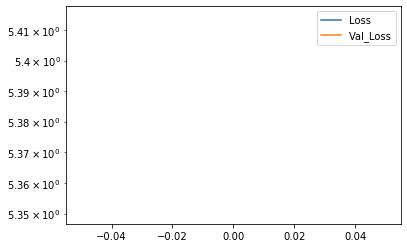

In [25]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [21]:
X1 = X[-10:]
X1 = np.reshape(X1, (10,100,36))

In [22]:
predicted = vae.predict(X1)

In [23]:
for ind in np.arange(0,predicted.shape[0]):
    print(smiles_decoder(predicted[ind]))

!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCcccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
!C1ccccccc1cCCccccccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

In [24]:
smiles_decoder(X1[-10])

'!Cc1cccnc1NC(=O)c2ccc3c(c2)sc(n3)N                                                                  '

In [87]:
import h5py

In [89]:
h5f = h5py.File('smiles_50k.h5', 'r')

In [93]:
h5f.keys()

<KeysViewHDF5 ['table']>

In [99]:
data_train = h5f['table']['axis0']